In [29]:
import matplotlib.pyplot as plt
import seaborn as sns # библиотека для красивого и чуть упрощенного рисования графиков
import pandas as pd
import numpy as np
%matplotlib inline

sns.set(style="darkgrid")

# Часть 0. Введение в линейные модели

Напомним, что линейная регрессия - это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию - значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее мало толку. Такую модель называет *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример. Пусть $x \sim U[0; 1]$, $y(x) = \cos(1.5\pi x)$. Представим, что мы наблюдаем пары $(x_i, \tilde{y}_i)$, где значение $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.1)$ (в реальной жизни значения целевой переменной могут быть зашумлены). Попытаемся обучить три разных линейных модели: признаки для первой -  $\{x\}$, для второй - $\{x, x^2, x^3, x^4\}$, для третьей - $\{x, \dots, x^{20}\}$

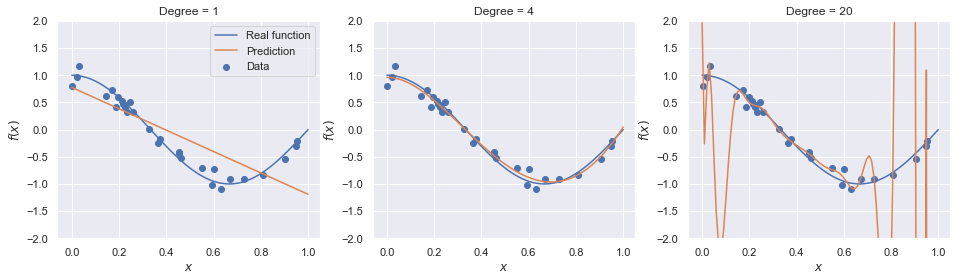

In [30]:
from sklearn.linear_model import LinearRegression # импортируем линейную регрессию
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(36)
x = np.linspace(0, 1, 100) # делим [0, 1] на 100 одинаковых частей, делаем сетку
y = np.cos(1.5 * np.pi * x) # делаем функцию по сетке

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree).fit_transform(x_objects[:, None]) # делаем полиномиальные фичи
    X = PolynomialFeatures(degree).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

**Вопрос 1**: Почему первая модель недообучилась, а третья переобучилась?

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связано с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ - коэффициентом регуляризации. Более подробно о регуляризации и переобучении вы узнаете из лекций.

**Вопрос 2**: Почему большие веса в линейной модели - плохо?

**Вопрос 3**: Почему регуляризовать $w_0$ - плохая идея?

**Вопрос 4**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? Что будет, если $\lambda$ сделать слишком большим?

# Часть 1. Загружаем данные

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные.

In [31]:
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Первое, что стоит заметить, - у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

In [32]:
from sklearn.model_selection import train_test_split

data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Посмотрим сначала на значения целевой переменной. Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

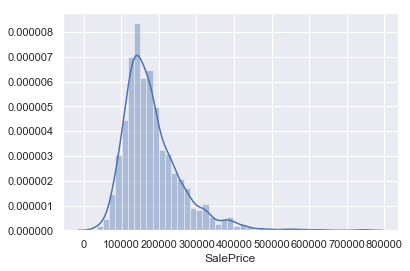

In [33]:
sns.distplot(y_train)

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать категориальные признаки.

**Вопрос**: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

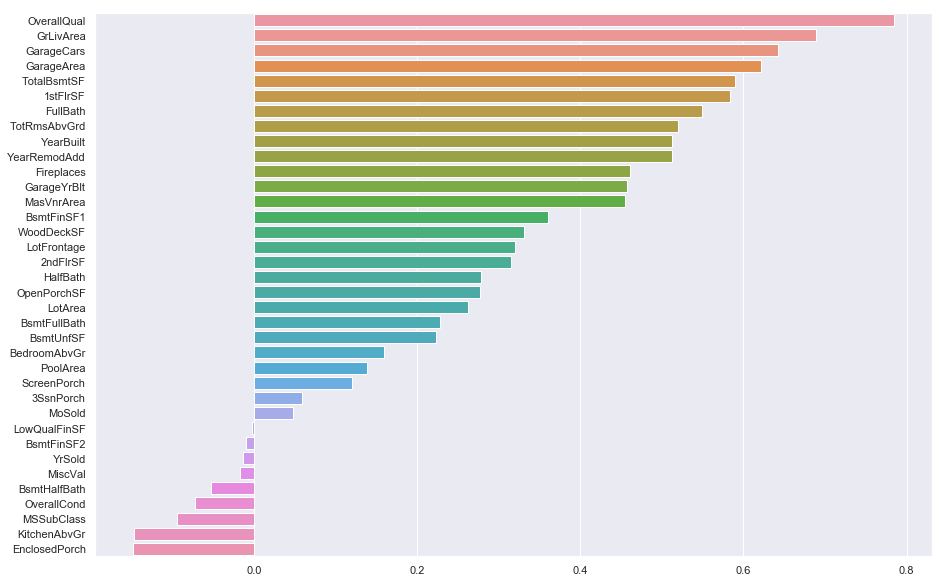

In [34]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean) # заполняем NaN-значения средним
X_test = X_test.fillna(numeric_data_mean)

correlations = {
    feature: np.corrcoef(X_train[feature], y_train)[0][1]
    for feature in numeric_features
}
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
features_order = [x[0] for x in sorted_correlations]
correlations = [x[1] for x in sorted_correlations]

plot = sns.barplot(y=features_order, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка:

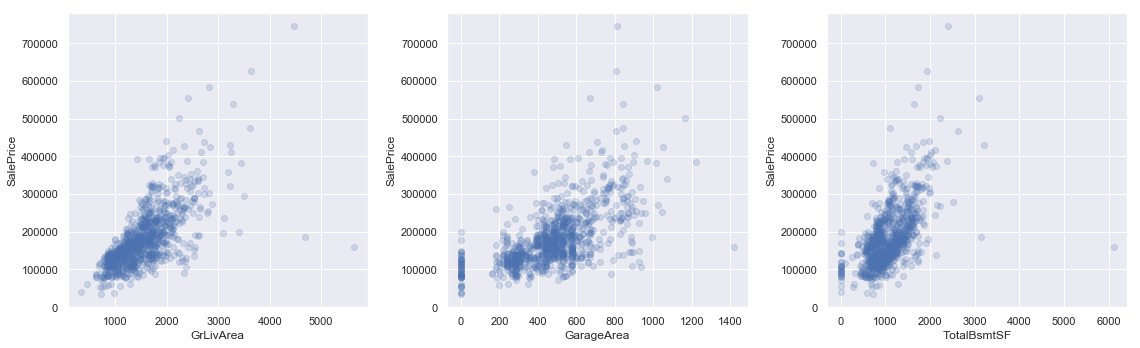

In [35]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

# Часть 2. Первая модель

В качестве метрики качества в соревновании использовалось RMSE (Root Mean Squared Error):
$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

RMSE в чистом виде не входит в стандартные метрики `sklearn`, но мы всегда можем определить свою метрику и использовать ее в некоторых функциях `sklearn`, например, `cross_val_score`. Для этого нужно воспользоваться `sklearn.metrics.make_scorer`

In [36]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

In [37]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % rmse(y_test, best_constant))
print("Train RMSE with best constant = %.4f" % rmse(y_train, best_constant))

Test RMSE with best constant = 83545.1780
Train RMSE with best constant = 77579.4784


Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* `LinearRegression` - "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* `Ridge` - линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* `Lasso` - линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [38]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))

Test RMSE = 35244.1905
Train RMSE = 34575.8211


Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

In [39]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
# Осторожно! cv=10 по умолчанию не делает shuffle от выборки!
# Рекомендуется указывать в явном виде KFold/StratifiedKFold с нужным параметром shuffle

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

('Cross validation scores:\n\t', '-48860.2087\n\t-29033.3696\n\t-46573.2970\n\t-71514.6486\n\t-37978.7182\n\t-27750.1349\n\t-26743.3246\n\t-27124.8223\n\t-27063.5443\n\t-28770.4656')
Mean CV RMSE = 37141.2534


Обратите внимание на то, что результаты `cv_scores` получились отриацтельными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные метрики называются `negative_*`, например, `sklearn.metrics.negative_mean_squared_error`

Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес - тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

In [40]:
def show_weights(features, weights):
    sorted_weights = sorted(zip(weights, features), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    plot = sns.barplot(y=features, x=weights)
    plot.figure.set_size_inches(10, 10)

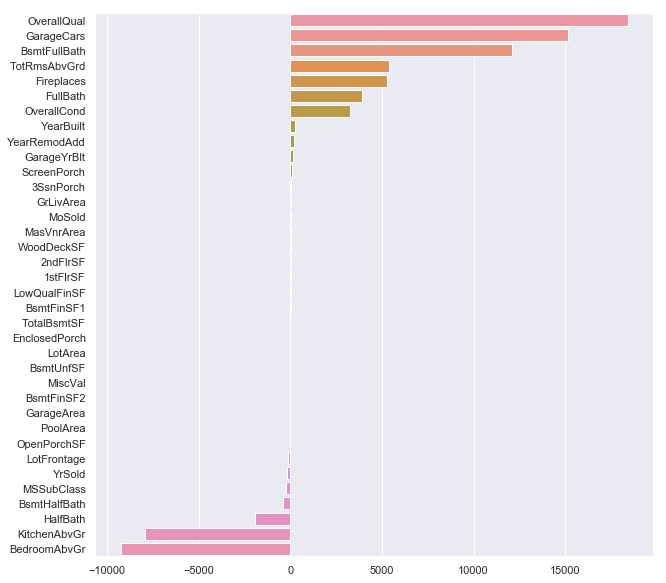

In [41]:
show_weights(numeric_features, model.coef_)

Будем шкалировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

Для этого воспользуемся трансформером `StandardScaler`. Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])
# обратите внимание, обучаем скейлер на тренировочных данных, и тестовые данные изменяем с помощью него!

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))

Test RMSE = 35244.8586
Train RMSE = 34575.7822


/Users/evgeny/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


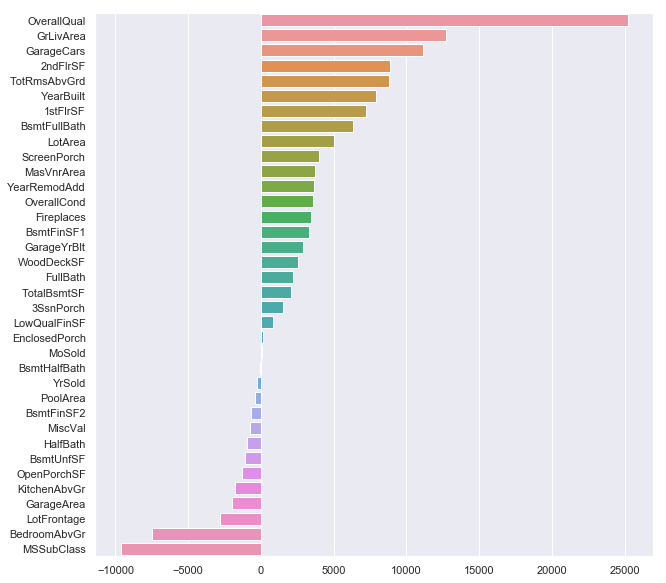

In [43]:
show_weights(numeric_features, model.coef_)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гипермараметры. У нашей модели это `alpha` - коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины)

Best alpha = 162.3777


/Users/evgeny/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Text(0,0.5,'CV score')

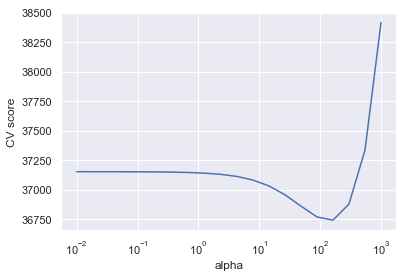

In [44]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)  # логарифмическая сетка
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring=rmse_scorer, cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом `Pipeline`, чтобы каждый раз не обрабатывать отдельно обучающую и тестовую выборки

In [45]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

Test RMSE = 35295.8827


# Часть 3. Работаем с категориальными признаками

Сейчас мы явно вытягиваем из данных не всю информацию, что у нас есть, просто потому, что мы не используем часть признаков. Эти признаки в датасете закодированы строками, каждый из них обозначает некоторую категорию. Такие признаки называются категориальными. Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

In [46]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [47]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1426,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
26,RL,Pave,NotGiven,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
395,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,Attchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
637,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,...,BuiltIn,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1296,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками - `LabelEncoder` (просто перенумеровывает значения признака натуральными числами) и `OneHotEncoder`.

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из всех нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

**Вопрос**: Проинтерпретируйте, что означают веса модели перед OneHot-кодированными признаками. Почему пользоваться `LabelEncoder` в случае линейной модели - скорее плохой вариант? Какие недостатки есть у OneHot-кодирования?

In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

Test RMSE = 39079.6587


Посмотрим на размеры матрицы после OneHot-кодирования:

In [49]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

('Size before OneHot:', (1022, 79))
('Size after OneHot:', (1022, 263))


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

In [50]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('scaling', StandardScaler()),
    ('regression', Lasso())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % rmse(y_test, y_pred))

RMSE = 39075.7055


In [51]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('scaling', StandardScaler()),
    ('regression', Lasso(500, max_iter=3000))
])

y_train_new = np.minimum(y_train, np.quantile(y_train, 0.99))

model = pipeline.fit(X_train, y_train_new)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % rmse(y_test, y_pred))

RMSE = 37569.7356
